# Fitting a scaled LDA model via proximal gradient descent
_Date:_ September 17, 2024

**Background.**
Latent Dirichlet allocation (LDA) assumes that all words in a document are distributed with identical dispersion.

Given observations $\mathbf{x}$, where $x_{mv}\in\mathbb{N}$ for document $m\in\{1,\ldots,M\}$ and word $v \in \{1,\ldots,V\}$.
Specifically, a $K$-topic LDA model assumes the follow generative process:

\begin{align*}
\mathbf{\theta}_k \sim \textrm{Dir}(\mathbf{\alpha}_\theta)& && \textrm{word distribution for topic } k, \Delta_V\\
\textrm{for } m=1,\ldots,M: & \\
C_m &\sim\textrm{Poi}(\xi) && \textrm{total word count in document } m, \mathbb{N} \\
\mathbf{\beta}_m &\sim \textrm{Dir}(\mathbf{\alpha}_\beta) && \textrm{topic distribution for document } m, \Delta_K\\
x_{mv} \mid C_{m}, \mathbf{\beta}_m, \mathbf{\theta}_{:v} &\sim \textrm{Poi}\left(C_m \lambda_{mv} \right)
    && \textrm{count of word } v \textrm{ in document } m, \mathbb{N}; \\
& && \textrm{rate } \lambda_{mv} = \textstyle{\sum_k}\beta_{mk}\mathbf{\theta}_{kv} \textrm{ and } \mathbf{\lambda}_m\in \Delta_V \\
(x_{m1},\ldots,x_{mV}) \mid \textstyle{\sum_v x_{mv} = C_{m}}, \mathbf{\beta}_m 
&\sim \textrm{Multinoimal}(C_m, \pi_m) && \pi_m = \left(\frac{\lambda_{m1}}{\sum_v\lambda_{mv}}, \ldots, \frac{\lambda_{mV}}{\sum_v\lambda_{mv}} \right)
\end{align*}
Since $\lambda_m \in \Delta_V$, we can interpret the Poisson distribution's rate $C_m\lambda_{mv}$ as the expected fraction of words the document $m$ that is assigned to word $v$.

In many cases, however, the assumption of similar dispersion of all words in the vocabulary is unrealistic.
This is evidenced in the need to preprocess the input texts and remove highly used words such as articles (e.g. the, a) and conjunctions (e.g. and, for).

One way to account for the differences in dispersion in different words, while retaining the the interpretation of $\mathbf{\theta}$ as topics and $\beta_m$ as the topic usages in a document,
is to explicitly model different dispersions for the different words. We refer to this model as a scaled LDA model.


**Model.**
Previously, drawing only the count of the words in the whole document, $C_m$, implicitly assumed that $\mathbb{E}[C_{mv}] = \frac{1}{V} C_m$ for all $v=1,\ldots,V$. 
We can understand the multinomial probability above as
$$
\pi_m = \left(
    \frac{\frac{C_{m1}}{\sum_v C_{mv}}\lambda_{m1}}{\sum_v\frac{{C_{mv}}}{\sum_v C_{mv}}\lambda_{mv}}, 
    \ldots,
    \frac{\frac{C_{mV}}{\sum_v C_{mv}}\lambda_{mV}}{\sum_v\frac{{C_{mv}}}{\sum_v C_{mv}}\lambda_{mv}}, \right)
$$


In the scaled LDA model, however, we explicitly model different expected counts for different words, $C_{mv}$. Now,

\begin{align*}
\mathbf{\theta}_k \sim \textrm{Dir}(\mathbf{\alpha}_\theta)&\\
\textrm{for } m=1,\ldots,M: & \\
C_{mv} &\sim\textrm{Poi}(\xi_v) && \textrm{Soft upper count of word $v$ in document } m, \mathbb{N} \\
\mathbf{\beta}_m &\sim \textrm{Dir}(\mathbf{\alpha}_\beta)\\
x_{mv} \mid C_{mv}, \mathbf{\beta}_m, \mathbf{\theta}_{:v} &\sim \textrm{Poi}\left(C_{mv} \lambda_{mv} \right).
\end{align*}
The variable $C_{mv}$ is described as the soft upper count of word $v$ because it can be thought loosely as the maximum counts of word $v$ in the document, and rate $\lambda_{mv}$ sets the fraction of that usage. However, recall that the upper limit support of any Poisson distribution is at infinity, and $\mathbb{E}[x_{mv}] = \mathbb{V}[X_{mv}] = C_{mv} \lambda_{mv}$, so $C_{mv}$ is not even a loose maximum, but simply a loose upper bound.

**Algorithm.** TODO

In [1]:
from functools import partial
from jax import jit, grad, lax, vmap
import jax.numpy as jnp
import jax.random as jr

from scipy.spatial.distance import cdist 
from scipy.optimize import linear_sum_assignment

import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions

import matplotlib.pyplot as plt

import jax

In [2]:
# Validate that we're using a tfp version with corrected effective seeds
# Using `tfp-nightly=0.25.0.dev20240920` NOT 
# See: https://github.com/tensorflow/probability/issues/1838

key = jr.key(2340)
tfd.Multinomial(100, probs=jnp.ones(10)/10.).sample(seed=key)

# If using tensorflow-probability=0.24.0, these lines would result in
#   OverflowError: Python int too large to convert to C long

2024-09-24 17:40:51.127019: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version (12.6.20). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Array([11., 12., 13., 17., 12.,  7., 10.,  2.,  4., 12.], dtype=float32)

## Proximal gradient descent

### Generic PGD with backtracking line search

In [3]:
def prox_grad_descent(objective,
                      prox,
                      init_params,
                      max_num_steps=100,
                      max_num_backtrack_steps=100,
                      max_stepsize=1.0,
                      discount=0.9,
                      tol=1e-6,
                      verbosity=0):
    r""" Run proximal gradient descent on an objective using the given
    proximal operator.

    prox: params x stepsize -> new_params
    """
    # We need the gradient of the objective
    g = jit(objective)
    dg = jit(grad(objective))

    # Run proximal gradient descent until convergence
    def _step_cond(state):
        _, old_obj, curr_obj, counter = state
        return (abs(curr_obj - old_obj) > tol) & (counter <= max_num_steps)

    def _step_body(state):
        params, _, curr_obj, counter = state

        # Define the condition and body of a while loop for backtracking line search
        def _backtrack_cond(backtrack_state):
            stepsize, backtrack_counter = backtrack_state

            # Compute generalized gradient
            G = (params - prox(params - stepsize * dg(params), stepsize)) / stepsize

            # Update params and evaluate objective
            new_params = params - stepsize * G
            new_obj = g(new_params)

            # Compute upper bound on objective via quadratic Taylor approx
            lower_bound = g(params) \
                - stepsize * jnp.sum(dg(params) * G) \
                    + 0.5 * stepsize * jnp.sum(G**2)

            # Continue to decrease stepsize while objective exceeds lower bound
            # return (new_obj > lower_bound) & (backtrack_counter < max_num_steps)
            return (new_obj > lower_bound) & (backtrack_counter < max_num_backtrack_steps)

        def _backtrack_body(backtrack_state):
            stepsize, backtrack_counter = backtrack_state
            return stepsize * discount, backtrack_counter + 1

        # Run backtracking line search to find stepsize
        stepsize, _ = lax.while_loop(_backtrack_cond, _backtrack_body, (max_stepsize, 0))

        # Perform update with this stepsize
        G = (params - prox(params - stepsize * dg(params), stepsize)) / stepsize
        new_params = params - stepsize * G
        new_obj = g(new_params)
        return new_params, curr_obj, new_obj, counter + 1

    params, _, _, _ = lax.while_loop(_step_cond, _step_body, (init_params, jnp.inf, 0.0, 0))
    return params

### Proximal operator to project onto the simplex

In [4]:
@jit
def _simplex_lagrangian(w, lmbda):
    return jnp.sum(jnp.clip(w - lmbda, a_min=0.0)) - 1.0


def bisect_jax(f, a, b, tol=1e-6, max_iter=50):
    """Find a root of f via bisection.

    Args:
        f: a function that is monotonically increasing or decreasing on the interval [a, b]
        a: lower bound on root
        b: upper bound on root
    """
    def _bisect_cond(state):
        (a, f_a), (b, f_b), counter = state
        # m = (a + b) / 2
        return (abs(f(a)) > tol) & ((b - a) / 2 > tol) & (counter < max_iter)

    def _bisect_body(state):
        (a, f_a), (b, f_b), counter = state
        m = (a + b) / 2
        f_m = f(m)
        # if sign(f(m)) = sign(f(m)) then a <- m else b <- m // new interval
        state = lax.cond(jnp.sign(f_m) == jnp.sign(f_a),
                        lambda: ((m, f_m), (b, f_b), counter+1), # predicate true
                        lambda: ((a, f_a), (m, f_m), counter+1), # predicate false
                        )
        return state

    init_state = ((a, f(a)), (b, f(b)), 0)
    ((a, fa), (b, fb), counter) = lax.while_loop(_bisect_cond, _bisect_body, init_state)
    # print("num iters: ", counter)
    return a


def project_simplex(w, dummy_stepsize):
    """Project onto simplex following the approach in Ch 6.2.5 of
    https://web.stanford.edu/~boyd/papers/pdf/prox_algs.pdf
    """
    lmbda_max = jnp.max(w)
    lmbda_star = bisect_jax(partial(_simplex_lagrangian, w),
                            lmbda_max - 1, lmbda_max)
    return jnp.clip(w - lmbda_star, a_min=0.0)

In [5]:
# Test it on some inputs
for w in [
    jnp.array([0.2, 0.9, 1.4]),  # not on the simplex, positive inputs
    jnp.array([-0.4, 0.9, 0.2]),  # not on the simplex, negative inputs
    jnp.array([0.33, 0.33, 0.33]),  # already on the simplex
]:
    what = project_simplex(w, 0)
    print(w, '->', what)
    assert jnp.all(what >= 0) & jnp.isclose(what.sum(), 1.0)

[0.2 0.9 1.4] -> [0.        0.2500019 0.7500019]
[-0.4  0.9  0.2] -> [0.         0.8500004  0.15000041]
[0.33 0.33 0.33] -> [0.33333397 0.33333397 0.33333397]


### Minimize a sum of gamma negative log likelihoods

In [6]:
objective = lambda x, shapes, rates: \
    -1.0 * tfd.Gamma(shapes, rate=rates).log_prob(jnp.clip(x, a_min=1e-4)).sum()

Start with special case of equal rates, in which case the optimum should be the normalized shapes minus one. This follows from the fact that the objective looks like a Dirichlet negative log probability.

In [7]:
shapes = jnp.array([2.0, 3.0, 4.0, 5.0])
K = len(shapes)
rates = jnp.ones(K)

x0 = jnp.ones(K) / K
xstar = prox_grad_descent(lambda x: objective(x, shapes, rates),
                          project_simplex,
                          x0,
                          max_stepsize=1.0)

jnp.set_printoptions(precision=3)
print(xstar)
print((shapes - 1) / (shapes - 1).sum())

[0.1 0.2 0.3 0.4]
[0.1 0.2 0.3 0.4]


Make sure it doesn't depend on the actual value of the rates.

In [8]:
shapes = jnp.array([2.0, 3.0, 4.0, 5.0])
K = len(shapes)
rates = 10 * jnp.ones(K)

x0 = jnp.ones(K) / K
xstar = prox_grad_descent(lambda x: objective(x, shapes, rates),
                          project_simplex,
                          x0,
                          max_stepsize=1.0)

jnp.set_printoptions(precision=3)
print(xstar)
print((shapes - 1) / (shapes - 1).sum())

[0.1 0.2 0.3 0.4]
[0.1 0.2 0.3 0.4]


Finally, let's try this with a variables with different rates.

In [9]:
shapes = jnp.array([2.0, 3.0, 4.0, 5.0])
K = len(shapes)
rates = jnp.array([1.0, 2.0, 3.0, 4.0])

x0 = jnp.ones(K) / K
xstar = prox_grad_descent(lambda x: objective(x, shapes, rates),
                          project_simplex,
                          x0,
                          max_stepsize=0.01)
jnp.set_printoptions(precision=3)
print(xstar)
print((shapes - 1) / (shapes - 1).sum())


[0.123 0.22  0.297 0.36 ]
[0.1 0.2 0.3 0.4]


Now, let's check whether the scale of the (different) rates matters.

In [12]:
shapes = jnp.array([2.0, 3.0, 4.0, 5.0])
K = len(shapes)
rates = 0.1 * jnp.array([1.0, 2.0, 3.0, 4.0])

x0 = jnp.ones(K) / K
xstar = prox_grad_descent(lambda x: objective(x, shapes, rates),
                          project_simplex,
                          x0,
                          max_stepsize=0.01)
jnp.set_printoptions(precision=3)
print(xstar)
print((shapes - 1) / (shapes - 1).sum())


[0.102 0.202 0.3   0.396]
[0.1 0.2 0.3 0.4]


Let's check that the solution is in fact an optimum, at least along a 1D slice of the simplex.

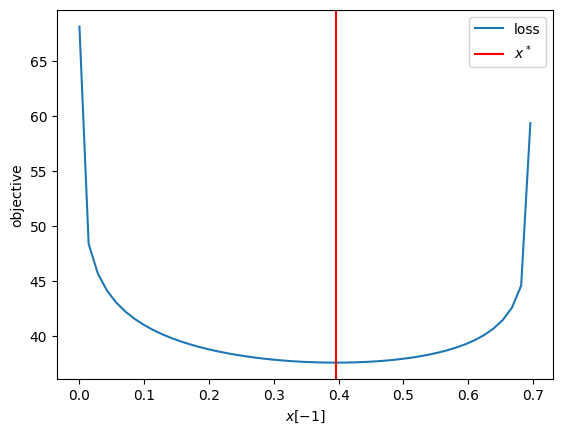

In [13]:
thr = 1 - xstar[:-2].sum()
vs = jnp.linspace(0, thr)
test_xs = jnp.tile(xstar, (50, 1))
test_xs = test_xs.at[:, -1].set(vs)
test_xs = test_xs.at[:, -2].set(thr - vs)
assert jnp.allclose(test_xs.sum(axis=1), 1.0)

plt.plot(vs, [objective(x, shapes, rates) for x in test_xs], label="loss")
plt.axvline(xstar[-1], color='r', label=r"$x^*$")
plt.xlabel(r"$x[-1]$")
plt.ylabel("objective")
plt.legend()

## Scaled LDA

Using the PGD method should find parameters exactly equivalent to the standard LDA algorithm.

### Generate data

In [93]:
def sample_scaled_lda(
    key,
    n_topics,
    vocab_size,
    n_docs,
    doc_length,
    prior_params,
):
    """Sample data from latent Dirichlet allocation model.

    Params
    ------
    key: JAX PRNGKey
    M: Number of documents
    K: Number of topics
    V: Vocab size, or number of words
    N: document length, expected document length in poisson sampling case
    vocab_rate: float or array of length (V,).
    topic_vocab_conc: float. Prior concentration parameter over words.
    doc_topic_conc: float. Prior concentration parameter over topics.
    scale_conc: float. As scale_conc -> infty, scales -> 1/V * ones, i.e. standard LDA formulation

    Returns
    -------
    data: int array, shape (M, V)
        Each row (data.sum(axis=-1) sums to C_m)
    params: dict of intermediate variable realizations
    """

    K = n_topics
    M = n_docs
    N = doc_length
    V = vocab_size

    theta_key, beta_key, scale_key, data_key = jr.split(key, 4)

    # Smaple variables
    topics = jr.dirichlet(
        theta_key, jnp.ones(V)*prior_params['topic_vocab_conc'], shape=(K,)
    )  # shape (K,V)
    weights = jr.dirichlet(
        beta_key, jnp.ones(K)*prior_params['doc_topic_conc'], shape=(M,)
    )  # shape (M,K)

    scales = jr.dirichlet(
        scale_key, jnp.ones(V)*prior_params['scale_conc']
    ) # shape (V,). In vanilla LDA, scales = 1/V.

    rates = scales * (weights @ topics)  # shape (M,V)
    rates /= rates.sum(axis=-1, keepdims=True)
    data = tfd.Multinomial(N, probs=rates).sample(seed=data_key)

    # Return intermediate variables
    params = dict(
        topics=topics,
        weights=weights,
        scales=scales,
    )

    return data, params

key = jr.key(52)

n_docs = 5000
n_topics = 3
doc_length = 1000
vocab_size = 10

prior_params = dict(
    topic_vocab_conc=1.1,
    doc_topic_conc=1.,
    scale_conc=1.,         # to recover standard LDA, set scale_conc -> infty
)

data, true_params = sample_scaled_lda(
    key,
    n_topics=n_topics,
    vocab_size=vocab_size,
    n_docs=n_docs,
    doc_length=doc_length,
    prior_params=prior_params,)

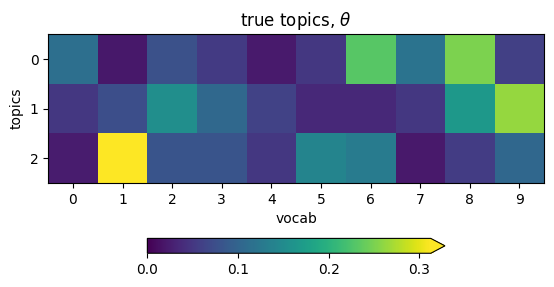

Text(0.5, 1.0, 'true scales, $\\sigma$')

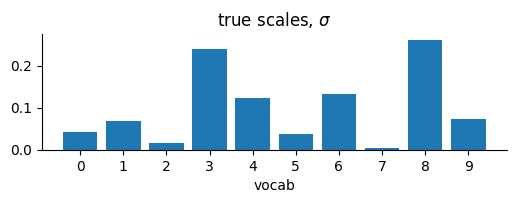

In [94]:
ax = plt.gca()
im = ax.imshow(true_params['topics'], vmin=0)
plt.colorbar(
    im, ax=ax, fraction=0.05, shrink=0.6, extend="max",
    orientation='horizontal', pad=0.15
)

ax.set_xticks(range(vocab_size))
ax.set_xlabel("vocab")

ax.set_yticks(range(n_topics))
ax.set_ylabel("topics")

ax.set_title(r'true topics, $\theta$')

plt.show()

plt.figure(figsize=(6,1.5))
ax = plt.gca()
ax.bar(range(vocab_size), true_params['scales'])
ax.spines[['top', 'right']].set_visible(False)
ax.set_xticks(range(vocab_size))
ax.set_xlabel("vocab")
ax.set_title(r'true scales, $\sigma$')

**Figure.** Topic-word distribution from the generating distribution. Each row is a probability vecotr and sums to 1.

Text(0.5, 0.98, 'word usage histograms')

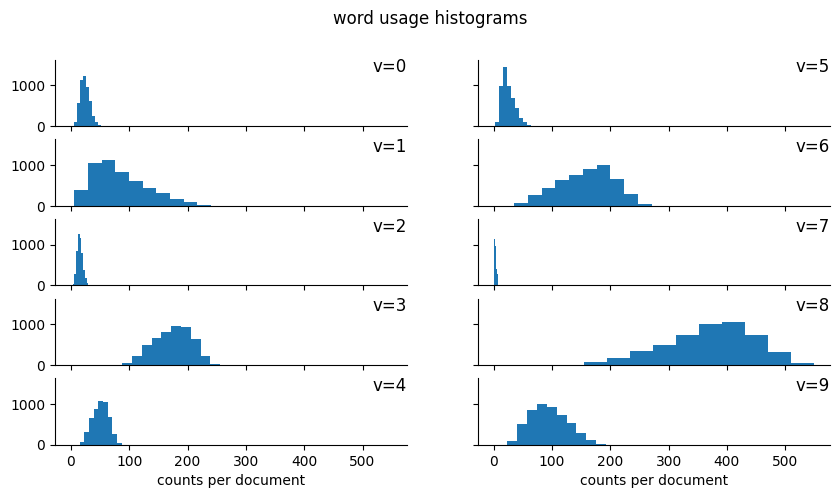

In [95]:
ncols = 2
nrows = vocab_size // ncols
fig, axs = plt.subplots(
    nrows=nrows, ncols=ncols, sharex=True, sharey=True, squeeze=False,
    figsize=(5*ncols, 1*nrows)
)

for v in range(vocab_size):
    i_row, i_col = v % nrows, v // nrows

    ax = axs[i_row, i_col]
    ax.hist(data[:,v])

    ax.set_title(f"{v=}", x=1, y=.9, ha='right', va='top')
    ax.spines[['top', 'right']].set_visible(False)

# Label x-axis of bottom row
for ax in axs[-1,:]:
    ax.set_xlabel("counts per document")

fig.suptitle('word usage histograms')

**Figure.** Histogram of word usages per document. The mode for each word differs, but they have dispersion on the same scale as their mode. This is consistent with a Poisson prior on counts per word.

### Infer parameters with variational Bayes

In [96]:
# Infer with variational Bayes (VB)
from sklearn.decomposition import LatentDirichletAllocation as LDA

lda = LDA(n_topics,)

lda.fit(data)

vb_topics = lda.components_ / lda.components_.sum(axis=1, keepdims=True)
vb_weights = lda.transform(data)

# find best permutation
# jensen-shanno divergence: total divergence to the average
# a smoothed and symmetrized version of KL divergence, with bounding between 0 and 1.
cost_matrix = cdist(true_params['topics'], vb_topics, metric='jensenshannon')
_, i_permute = linear_sum_assignment(cost_matrix)

vb_topics = vb_topics[i_permute]
vb_weights = vb_weights[:,i_permute]

Text(0.5, 0, 'vocab')

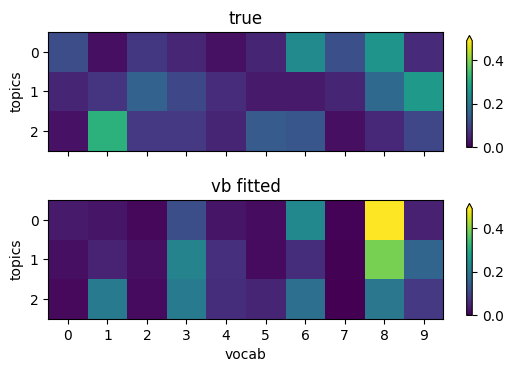

In [97]:
vmax = max(vb_topics.max(), true_params['topics'].max())

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6,4), sharex=True,)

for ax, topics, label in zip(axs, [true_params['topics'], vb_topics], ['true', 'vb fitted']):
    im = ax.imshow(topics, vmin=0, vmax=vmax)
    plt.colorbar(
        im, ax=ax, fraction=0.1, shrink=0.8, extend="max",
    )

    ax.set_xticks(range(vocab_size))


    ax.set_yticks(range(n_topics))
    ax.set_ylabel("topics")

    ax.set_title(label)

axs[-1].set_xlabel('vocab')

Text(0.5, 1.0, 'true weights')

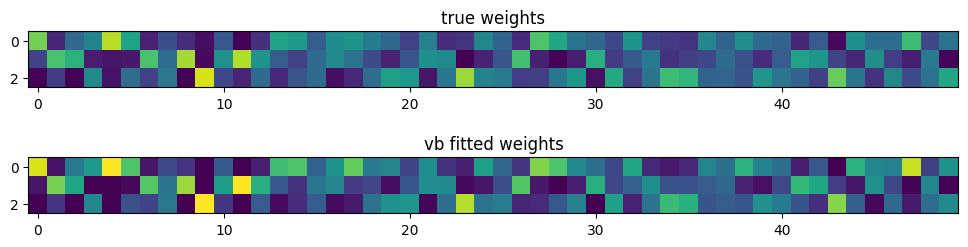

In [99]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(12,3))

ax = axs[1]
ax.imshow(vb_weights[:50].T, vmin=0, vmax=1)
ax.set_title('vb fitted weights')

ax = axs[0]
ax.imshow(true_params['weights'][:50].T, vmin=0, vmax=1)
ax.set_title('true weights')

### Infer parameters with EM and PGD

We compute the E-step as usual. For the M-step, we use the PGD algorithm. This should exactly calculate the maximizing values because the parameters should already lie in the simplex.

#### E-step

In [100]:
def e_step(data, params, prior_params):
    """Compute posterior expected sufficient statistics of parameters.

    Parameters
    ----------
    X: data tensor, shape (M,V)
    params: tuple of parameters
        weights: shape (M,K)
        topics: shape (K,V)
        scales: shape (V,)  # currently, given

    Returns
    -------
    expct_stats: dict of expected posterior statistics
    """

    weights, topics, scales = params

    # Compute expected likelihood
    rhos = scales * jnp.einsum('mk, kv -> mkv', weights, topics)
    rhos /= rhos.sum(axis=1, keepdims=True)
    zs = data[:,None,:] * rhos  # shape (M,K,V)

    # Compute expected sufficient statistics of weights parameter
    alpha_weights = zs.sum(axis=-1) + prior_params['doc_topic_conc'] # (M,K)
    beta_weights = (scales * topics).sum(axis=-1)# shape (K,)

    # Compute expected sufficient statistics of topics parameter
    alpha_topics = zs.sum(axis=0) + prior_params['topic_vocab_conc'] # (K,V)
    beta_topics = jnp.einsum('mk, v->kv', weights, scales) # shape (K, V)

    expct_stats = dict(
        doc_topic_conc = alpha_weights,
        doc_topic_rate = beta_weights,
        topic_vocab_conc = alpha_topics,
        topic_vocab_rate = beta_topics,
    )

    return expct_stats

In [101]:
# pass in true params to ensure the function runs
expct_stats \
    = e_step(data, (true_params['weights'], true_params['topics'], true_params['scales']), prior_params)

# unscaled lda
# expct_stats \
#     = e_step(data, (true_params['weights'], true_params['topics'], jnp.ones(vocab_size)/vocab_size), prior_params)

In [102]:
print('posterior expected doc-topic rates')
print(expct_stats['doc_topic_rate']/expct_stats['doc_topic_rate'].sum(axis=-1, keepdims=True))

posterior expected doc-topic rates
[0.381 0.337 0.282]


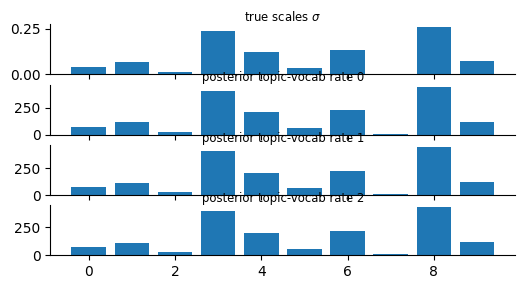

In [111]:
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(6,n_topics*1), sharex=True,)

for i, (ax, rate, lbl) in enumerate(zip(
    axs, [true_params['scales'], expct_stats['topic_vocab_rate'][0], expct_stats['topic_vocab_rate'][1], expct_stats['topic_vocab_rate'][2]], [r'true scales $\sigma$', 'posterior topic-vocab rate 0', 'posterior topic-vocab rate 1', 'posterior topic-vocab rate 2']
)):
    ax.bar(range(vocab_size), rate)
    ax.set_title(lbl, y=0.9, fontsize='small')

    ax.spines[['top', 'right']].set_visible(False)

# => doc_topic_rates effectively learning true scales

In [112]:
expct_stats['topic_vocab_rate']

Array([[ 71.714, 112.902,  26.748, 403.854, 206.155,  61.603, 223.805,
          7.6  , 439.238, 121.615],
       [ 72.655, 114.384,  27.099, 409.152, 208.86 ,  62.411, 226.741,
          7.7  , 445.   , 123.211],
       [ 69.673, 109.689,  25.987, 392.359, 200.288,  59.85 , 217.435,
          7.384, 426.736, 118.154]], dtype=float32)

#### M-step

In [104]:
# def m_step(ss_weights, ss_topics, weights_init, topics_init, max_num_steps=10, max_stepsize=1.0):

# alpha_weights, beta_weights = ss_weights
# alpha_topics, beta_topics = ss_topics

def m_step(expct_stats, init_weights, init_topics, max_num_steps=10, max_stepsize=1.0):
    """Compute parameters that maximize conditional posterior for weights and topics.

    Returns
    -------
    weights_star, topics_star
    """

    
    doc_topic_conc = expct_stats['doc_topic_conc']
    doc_topic_rate = expct_stats['doc_topic_rate']  # only shape (K,)
    doc_topic_rate = jnp.tile(doc_topic_rate, (len(doc_topic_conc), 1))  # now, shape (M,K)

    M = len(doc_topic_conc)

    topic_vocab_conc = expct_stats['topic_vocab_conc']
    topic_vocab_rate = expct_stats['topic_vocab_rate'] # only shape (K, V,)

    @vmap
    def v_prox_grad_descent(init_param, alpha, beta):
        return prox_grad_descent(
            lambda x: objective(x, alpha, beta) / M,
            project_simplex,
            init_param,
            max_num_steps=max_num_steps,
            max_stepsize=max_stepsize # share stepsize for now
        )

    # vmap over dimension length M
    weights = v_prox_grad_descent(init_weights, doc_topic_conc, doc_topic_rate)

    # vmap over dimension length K
    topics =  v_prox_grad_descent(init_topics, topic_vocab_conc, topic_vocab_rate)

    return weights, topics

In [119]:
# init_weights = jnp.ones((n_docs, n_topics)) / n_topics
# init_topics = jnp.ones((n_topics, vocab_size)) / vocab_size

weights = true_params['weights']
topics = true_params['topics']

new_weights, new_topics = m_step(
    expct_stats, 
    init_weights,
    init_topics,
    max_num_steps=1,
    max_stepsize=0.01,
)

assert all(new_topics.sum(axis=-1))
assert all(new_weights.sum(axis=-1))

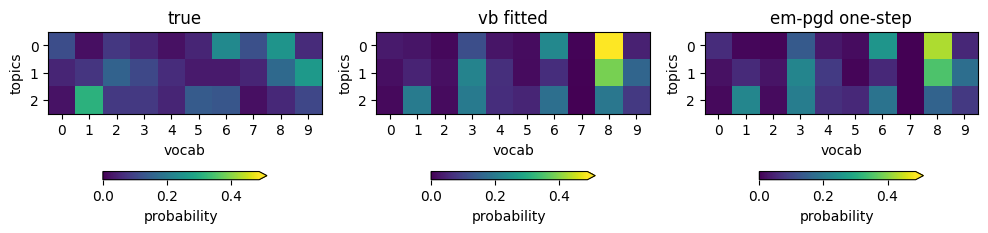

In [120]:
vmax = max(vb_topics.max(), true_params['topics'].max(), new_topics.max())

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,3))

for ax, topics, label in zip(axs, [true_params['topics'], vb_topics, new_topics], ['true', 'vb fitted', 'em-pgd one-step']):
    im = ax.imshow(topics, vmin=0, vmax=vmax)
    plt.colorbar(
        im, ax=ax, fraction=0.05, shrink=0.6, extend="max",
        orientation='horizontal', pad=0.25, label='probability'
    )

    ax.set_xticks(range(vocab_size))
    ax.set_xlabel("vocab")

    ax.set_yticks(range(n_topics))
    ax.set_ylabel("topics")

    ax.set_title(label)

Text(0.5, 0, 'document')

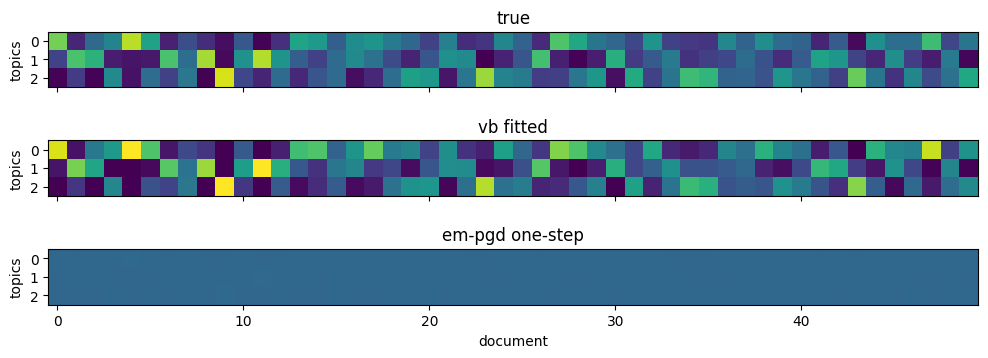

In [121]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(12,4), sharex=True)

for ax, topics, label in zip(axs, [true_params['weights'], vb_weights, new_weights], ['true', 'vb fitted', 'em-pgd one-step']):
    im = ax.imshow(topics[:50].T, vmin=0, vmax=1)

    ax.set_yticks(range(n_topics))
    ax.set_ylabel("topics")

    ax.set_title(label)

axs[-1].set_xlabel("document")